In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
print("Files in Google Drive KaggleDatasets folder:", os.listdir('/content/drive/MyDrive/KaggleDatasets'))


Files in Google Drive KaggleDatasets folder: ['training.1600000.processed.noemoticon.csv', 'twitter_training.csv', 'twitter_validation.csv', 'Tweets.csv', 'model_epoch_1.pth', 'best_model.pth', 'model_epoch_2.pth', 'checkpoint_epoch_1.pth', 'checkpoint_epoch_2.pth']


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
import re
# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bert model and tokenizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# for handling data loading and batching.
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


we're going to be using 3 datasets for inital training since our main dataset only has positive and negative classes. we will be grabbing the neutral class from different datasets

In [4]:
df = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1', header = None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ['target', 'id', 'date', 'query', 'user', 'text']



df = df[['target', 'text']]
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
df2 = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/twitter_training.csv', header = None)
df2.columns = [ 'id', 'entity','target', 'text']
df2.head()

,id,entity,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
print('Entity dataset:')
print(df2['target'].value_counts())
print()
print('sentiment140 dataset:')
print(df['target'].value_counts() )


Entity dataset:
target
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

sentiment140 dataset:
target
0    800000
4    800000
Name: count, dtype: int64


In [8]:
df2['target'] = df2['target'].replace('Irrelevant', 'Neutral')
df2['target'].value_counts()


,count
target,
Neutral,31308
Negative,22542
Positive,20832


In [9]:
sub_data = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/Tweets.csv', encoding = 'ISO-8859-1')
print(sub_data.head(10))
sub_data['sentiment'].value_counts()

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   
5  28b57f3990  http://www.dothebouncy.com/smf - some shameles...   
6  6e0c6d75b1  2am feedings for the baby are fun when he is a...   
7  50e14c0bb8                                         Soooo high   
8  e050245fbd                                        Both of you   
9  fc2cbefa9d   Journey!? Wow... u just became cooler.  hehe....   

                                       selected_text sentiment  
0                I`d have responded, if I were going   neutral  
1                                           Sooo SAD  negative  
2                                        bullying me  ne

,count
sentiment,
neutral,11118
positive,8582
negative,7781


In [10]:
sub_data = sub_data[['text','sentiment']]
sampled_neutral = sub_data[sub_data['sentiment']=='neutral']
print(sampled_neutral.head())
sampled_neutral['sentiment'] = sampled_neutral['sentiment'].replace('neutral', 2)
print(sampled_neutral.head())
# here wr are using differnet datasets to add the neutral class to our main dataset that will be used for training


                                                 text sentiment
0                 I`d have responded, if I were going   neutral
5   http://www.dothebouncy.com/smf - some shameles...   neutral
7                                          Soooo high   neutral
8                                         Both of you   neutral
10   as much as i love to be hopeful, i reckon the...   neutral
                                                 text  sentiment
0                 I`d have responded, if I were going          2
5   http://www.dothebouncy.com/smf - some shameles...          2
7                                          Soooo high          2
8                                         Both of you          2
10   as much as i love to be hopeful, i reckon the...          2


<ipython-input-10-b71f1e262b1d>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sampled_neutral['sentiment'] = sampled_neutral['sentiment'].replace('neutral', 2)
<ipython-input-10-b71f1e262b1d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_neutral['sentiment'] = sampled_neutral['sentiment'].replace('neutral', 2)


In [11]:

neutral_df = df2[df2['target']=='Neutral']
neutral_df = neutral_df.sample(frac=1, random_state=42).reset_index(drop=False)
half_size = len(neutral_df) // 2

neutral_half_1 = neutral_df.iloc[:half_size]#will be added to the first dataset

neutral_half_2 = neutral_df.iloc[half_size:]#will be kept in the entity dataset for fine tuning
df2_final = df2.drop(neutral_half_1['index'])
df2_final = df2_final.reset_index(drop=True)

print(df2_final['target'].value_counts())
print(neutral_half_1['target'].value_counts())
print(neutral_half_1.head())


target
Negative    22542
Positive    20832
Neutral     15654
Name: count, dtype: int64
target
Neutral    15654
Name: count, dtype: int64
   index     id        entity   target  \
0   7741   9330     Overwatch  Neutral   
1  18890  12437  WorldOfCraft  Neutral   
2  29545    680   ApexLegends  Neutral   
3  50793   6318          FIFA  Neutral   
4  54957   2237    CallOfDuty  Neutral   

                                                text  
0  Fun with friends (maybe a few mates... maybe)....  
1  Review: 'In Love and Warcraft' Serves Romance ...  
2  Two whole minutes could not even capture my fa...  
3  How the fuck does FIFA expect you to win again...  
4  she can sleep through me yelling for hours on ...  


In [12]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
neutral_half_1 = neutral_half_1[['target','text']]

neutral_half_1['target']= neutral_half_1['target'].replace('Neutral', 2)
df_main = pd.concat([df, neutral_half_1,], axis=0)
sampled_neutral = sampled_neutral[['sentiment','text']]

print(sampled_neutral.head())
print()
print(neutral_half_1.head())

    sentiment                                               text
0           2                I`d have responded, if I were going
5           2  http://www.dothebouncy.com/smf - some shameles...
7           2                                         Soooo high
8           2                                        Both of you
10          2   as much as i love to be hopeful, i reckon the...

   target                                               text
0       2  Fun with friends (maybe a few mates... maybe)....
1       2  Review: 'In Love and Warcraft' Serves Romance ...
2       2  Two whole minutes could not even capture my fa...
3       2  How the fuck does FIFA expect you to win again...
4       2  she can sleep through me yelling for hours on ...


<ipython-input-13-9952f7f36b8a>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  neutral_half_1['target']= neutral_half_1['target'].replace('Neutral', 2)


we're renaming the columns to consturct our final dataset that we will preprocess

In [14]:
sampled_neutral = sampled_neutral.rename(columns={'sentiment':'target'})
df_main = pd.concat([df_main,sampled_neutral],axis=0).reset_index(drop=True)
df_main['target'].value_counts()

,count
target,
0,800000
4,800000
2,26772


we finally got some natural class now

In [15]:
df_main.isna().sum()

,0
target,0
text,172


In [16]:
df_main = df_main.dropna()
df_main.isna().sum()

,0
target,0
text,0


In [17]:
def preProcess(text):
  if not isinstance(text, str):
    return""

  text = text.lower()
  text = re.sub(r'http\S+|WWW\S+|https\S+', '[URL]',text)
  text = re.sub(r'@\w+', '[USER]', text)

  text = re.sub(r'\s+', ' ', text).strip()

  return text
df_main['clean_text'] = df_main['text'].apply(preProcess)

df_main[['clean_text','text']]

,clean_text,text
0,"[USER] [URL] - awww, that's a bummer. you shou...","@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his facebook by ...,is upset that he can't update his Facebook by ...
2,[USER] i dived many times for the ball. manage...,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"[USER] no, it's not behaving at all. i'm mad. ...","@nationwideclass no, it's not behaving at all...."
...,...,...
1626767,"few grilled mushrooms and olives, feta cheese ...","few grilled mushrooms and olives, feta cheese ..."
1626768,94 more days till bh comes back to la,94 more days till BH comes back to LA
1626769,"i`m defying gravity. and nobody in alll of oz,...","i`m defying gravity. and nobody in alll of oz,..."
1626770,in spoke to you yesterday and u didnt respond ...,in spoke to you yesterday and u didnt respond...


In [18]:
df_main.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[USER] [URL] - awww, that's a bummer. you shou..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,[USER] i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","[USER] no, it's not behaving at all. i'm mad. ..."


In [19]:
X = df_main['clean_text']
y = df_main['target']
x_train,x_test, y_train,y_test = train_test_split(X,y, test_size=0.15, random_state=42)

## Tokenization

we will be using the besrt model trained on lower case english

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
def tokenize_texts(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Adds [CLS] and [SEP]
            max_length=max_len,
            padding='max_length',         # Pads to the max_length
            truncation=True,              # Truncates texts longer than max_length
            return_attention_mask=True,   # Generates attention masks
            return_tensors='pt'           # Returns PyTorch tensors
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks



Tokenizing the text

In [22]:
train_input_ids, train_attention_masks = tokenize_texts(x_train, tokenizer)
test_input_ids, test_attention_masks = tokenize_texts(x_test, tokenizer)

In [23]:
# Convert labels to tensors
# 0: negative
# 1: neutral
# 2: positive

label_mapping = {0: 0, 2: 1, 4: 2}
y_train_f = y_train.replace(label_mapping)
y_test_f = y_test.replace(label_mapping)

y_train_f = torch.tensor(y_train_f.values)
y_test_f = torch.tensor(y_test_f.values)

Create Dataloaders to efficiently load data in batches during training and evaluation.

In [24]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks,y_train_f)
test_dataset = TensorDataset(test_input_ids, test_attention_masks,y_test_f)

batch_size = 64
# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Samples data randomly
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),  # Samples data sequentially
    batch_size=batch_size
)

# Training

In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from transformers import get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,       # Updated to 3 labels
    output_attentions=False,
    output_hidden_states=False
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

#Calculate Class Weights
total_samples = 800000 + 800000 + 26772
num_classes = 3
samples_per_class = {
    0: 800000,
    1: 26772,     # Mapped class label for original label 2
    2: 800000
}

class_weights = []

for cls in sorted(samples_per_class.keys()):
    weight = total_samples / (num_classes * samples_per_class[cls])
    class_weights.append(weight)

# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Step 5: Define Custom Loss Function with Class Weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Step 6: Set Up the Optimizer and Scheduler
epochs = 3
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # Typically 10% of total steps
    num_training_steps=total_steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Optional section

In [29]:
checkpoint_path = '/content/drive/MyDrive/KaggleDatasets/checkpoint_epoch_2.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
print('Checkpoint keys:', checkpoint.keys())


<ipython-input-29-78761a31dbed>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_losses', 'validation_losses', 'best_val_loss'])


Due to long training hours I had to save model checkpoints so you don't have to run the cell right below if you finish the training in one go

In [34]:
model_state_dict = checkpoint['model_state_dict']
print('Model state dict keys:', model_state_dict.keys())

Model state dict keys: odict_keys(['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert

In [35]:
missing_keys, unexpected_keys = model.load_state_dict(model_state_dict, strict=False)
print('Missing keys:', missing_keys)
print('Unexpected keys:', unexpected_keys)

Missing keys: []
Unexpected keys: []


In [31]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the checkpoint
checkpoint_path = '/content/drive/MyDrive/KaggleDatasets/checkpoint_epoch_2.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Instantiate the model architecture
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the device
model.to(device)

# Calculate Class Weights
total_samples = 800000 + 800000 + 26772
num_classes = 3
samples_per_class = {
    0: 800000,
    1: 26772,    # Mapped class label for original label 2
    2: 800000
}

class_weights = []
for cls in sorted(samples_per_class.keys()):
    weight = total_samples / (num_classes * samples_per_class[cls])
    class_weights.append(weight)

# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the custom loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Load the optimizer state dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Ensure optimizer is on the correct device
for state in optimizer.state.values():
    if isinstance(state, dict):
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    elif isinstance(state, torch.Tensor):
        state = state.to(device)

# Recalculate total_steps and num_warmup_steps
epochs = 3  # Total number of epochs you plan to train
start_epoch = checkpoint['epoch']  # The epoch to resume from
remaining_epochs = epochs - start_epoch
print(remaining_epochs)
# Assuming you have your train_dataloader defined
# If not, you need to define it here
# train_dataloader = ...

total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.1 * total_steps)

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# Load the scheduler state dict
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Move scheduler states to the correct device
# You can now resume training from start_epoch


<ipython-input-31-e0d92220083d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Some weights of BertForSequen

1


## optional section end

In [36]:
def train(model, train_dataloader, optimizer, scheduler, device, loss_fn):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
            print(f'  Batch {step} of {len(train_dataloader)}.')

        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        optimizer.zero_grad()

        # Forward pass without labels
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks
        )

        logits = outputs.logits

        # Calculate custom loss
        loss = loss_fn(logits, batch_labels)

        total_loss += loss.item()

        # Backward pass
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Training loss: {avg_loss}')
    return avg_loss


In [37]:
# Step 8: Update the Evaluation Function (No changes needed)
 # Step 8: Update the Evaluation Function
def evaluate(model, test_dataloader, device, loss_fn):
    model.eval()
    total_loss = 0
    total_preds = []
    total_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(
                input_ids=batch_input_ids,
                attention_mask=batch_attention_masks
            )

            logits = outputs.logits

            # Calculate loss
            loss = loss_fn(logits, batch_labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()

            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_dataloader)
    accuracy = accuracy_score(total_labels, total_preds)
    precision = precision_score(total_labels, total_preds, average='weighted')
    recall = recall_score(total_labels, total_preds, average='weighted')
    f1 = f1_score(total_labels, total_preds, average='weighted')
    print(f'Validation Loss: {avg_loss}')
    print(f'Validation Accuracy: {accuracy:.4f}')
    print()
    report = classification_report(total_labels, total_preds, target_names=['Negative', 'Neutral', 'Positive'])
    print(report)
    return avg_loss, total_preds, total_labels

train_losses = checkpoint['train_losses']
validation_losses = checkpoint['validation_losses']
best_val_loss = checkpoint['best_val_loss']
checkpoint['best_val_loss']
start_epoch = checkpoint['epoch']  # This should be an integer representing the next epoch to run
epochs = 3  # Total number of epochs

for epoch in range(start_epoch,epochs+1):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('Training...')
    train_loss = train(model, train_dataloader, optimizer, scheduler, device, loss_fn)
    train_losses.append(train_loss)

    print('Evaluating...')
    val_loss, val_preds, val_labels = evaluate(model, test_dataloader, device, loss_fn)
    validation_losses.append(val_loss)

    # Check for best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Best model updated with validation loss: {best_val_loss:.4f}")

    # Save the checkpoint at the end of each epoch
    checkpoint = {
        'epoch': epoch + 1,  # Epoch number (start from 1)
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'validation_losses': validation_losses,
        'best_val_loss': best_val_loss
    }
    checkpoint_path = f'/content/drive/MyDrive/KaggleDatasets/checkpoint_epoch_{epoch + 1}.pth'
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved after epoch {epoch + 1} at {checkpoint_path}")

print("Training complete!")

# Plot Training and Validation Loss Over Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)

# Define class names based on your label mapping
class_names = ['Negative', 'Neutral', 'Positive']  # Adjust as necessary

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch 3/3
Training...
  Batch 100 of 21604.
  Batch 200 of 21604.
  Batch 300 of 21604.
  Batch 400 of 21604.
  Batch 500 of 21604.
  Batch 600 of 21604.
  Batch 700 of 21604.
  Batch 800 of 21604.
  Batch 900 of 21604.
  Batch 1000 of 21604.
  Batch 1100 of 21604.
  Batch 1200 of 21604.
  Batch 1300 of 21604.
  Batch 1400 of 21604.
  Batch 1500 of 21604.
  Batch 1600 of 21604.
  Batch 1700 of 21604.
  Batch 1800 of 21604.
  Batch 1900 of 21604.
  Batch 2000 of 21604.
  Batch 2100 of 21604.
  Batch 2200 of 21604.
  Batch 2300 of 21604.
  Batch 2400 of 21604.
  Batch 2500 of 21604.
  Batch 2600 of 21604.
  Batch 2700 of 21604.
  Batch 2800 of 21604.
  Batch 2900 of 21604.
  Batch 3000 of 21604.
  Batch 3100 of 21604.
  Batch 3200 of 21604.
  Batch 3300 of 21604.
  Batch 3400 of 21604.
  Batch 3500 of 21604.
  Batch 3600 of 21604.
  Batch 3700 of 21604.
  Batch 3800 of 21604.
  Batch 3900 of 21604.
  Batch 4000 of 21604.
  Batch 4100 of 21604.
  Batch 4200 of 21604.
  Batch 4300 of 2160

KeyboardInterrupt: 

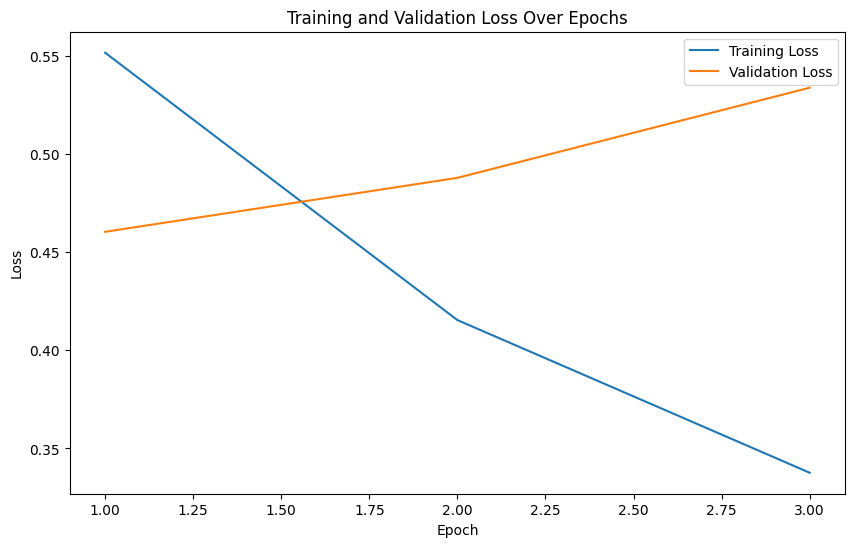

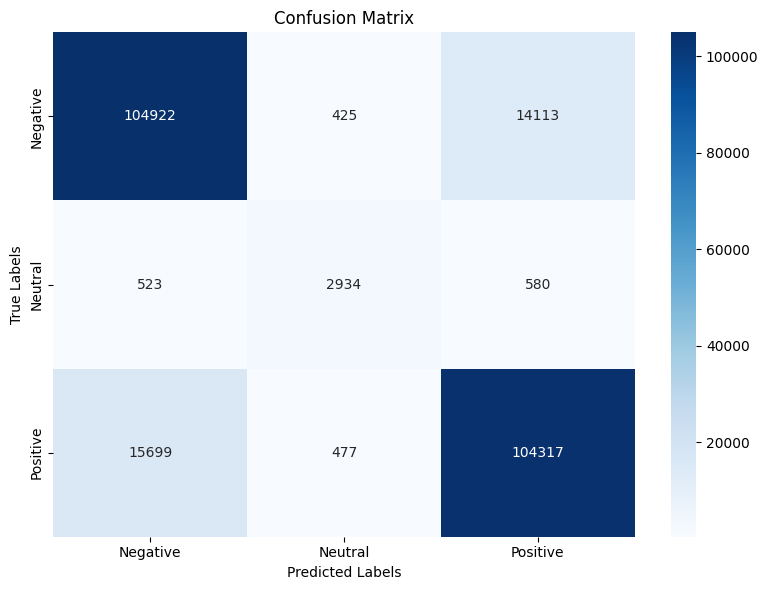

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Compute Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)

# Define class names based on your label mapping
class_names = ['Negative', 'Neutral', 'Positive']  # Adjust as necessary

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()

based on the training data it would be ideal to retrain the model and stop at epoch 1.6 to get the highest performance with the least overfitting possible

training was interupted a coulpe of times so we resorted to saving model checkpoints to continute training later


Training loss: 0.5518139284838682
Evaluating...
Validation Loss: 0.46047283155189517
Validation Accuracy: 0.8607

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86    119460
     Neutral       0.68      0.73      0.71      4037
    Positive       0.87      0.86      0.86    120493

    accuracy                           0.86    243990
   macro avg       0.80      0.82      0.81    243990
weighted avg       0.86      0.86      0.86    243990

Best model updated with validation loss: 0.4605
Checkpoint saved after epoch 1 at /content/drive/MyDrive/KaggleDatasets/checkpoint_epoch_1.pth


Training loss: 0.4154568425424699
Evaluating...
Validation Loss: 0.4879922523934354
Validation Accuracy: 0.8683

              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87    119460
     Neutral       0.78      0.72      0.75      4037
    Positive       0.88      0.86      0.87    120493

    accuracy                           0.87    243990
   macro avg       0.84      0.82      0.83    243990
weighted avg       0.87      0.87      0.87    243990

Checkpoint saved after epoch 2 at /content/drive/MyDrive/KaggleDatasets/checkpoint_epoch_2.pth
